# Load Dataset

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Concatenate, Dropout, Flatten, Lambda, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# file path in Google Drive
file_path = '/content/drive/MyDrive/BugTriage/bug_reports_anonymized_v1.csv'

try:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Print the first few rows of the DataFrame to verify
    print(df.head())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
    print(f"Error: Could not parse the CSV file at {file_path}. Check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Mounted at /content/drive
   bug_id                                        description      developer  \
0  323798                  Keyword URL Needs to be localized  developer_001   
1  322369                                   History importer  developer_002   
2  324237            Close button on tabs show empty tooltip  developer_003   
3  323472          Crash when Places imports FF1.5 bookmarks  developer_002   
4  322290  Queries in the bookmark toolbar/menu don't act...  developer_004   

   severity priority  project  
0    normal       P1  Firefox  
1    normal       P1  Firefox  
2     minor       P3  Firefox  
3  critical       P1  Firefox  
4     major       P2  Firefox  


In [ ]:
# Rename columns
df = df.rename(columns={'Assigned To': 'developer', 'Severity': 'severity', 'Priority': 'priority', 'Description': 'description'})
df.head()

,bug_id,description,developer,severity,priority,project
0,323798,Keyword URL Needs to be localized,developer_001,normal,P1,Firefox
1,322369,History importer,developer_002,normal,P1,Firefox
2,324237,Close button on tabs show empty tooltip,developer_003,minor,P3,Firefox
3,323472,Crash when Places imports FF1.5 bookmarks,developer_002,critical,P1,Firefox
4,322290,Queries in the bookmark toolbar/menu don't act...,developer_004,major,P2,Firefox


# Dataset cleaning

In [ ]:
# drop rows that has values other than p1,p2,p3,p4 or p5 in priority column
valid_priorities = ['P1', 'P2', 'P3', 'P4', 'P5']
df = df[df['priority'].isin(valid_priorities)]
print(df.head())

   bug_id                                        description      developer  \
0  323798                  Keyword URL Needs to be localized  developer_001   
1  322369                                   History importer  developer_002   
2  324237            Close button on tabs show empty tooltip  developer_003   
3  323472          Crash when Places imports FF1.5 bookmarks  developer_002   
4  322290  Queries in the bookmark toolbar/menu don't act...  developer_004   

   severity priority  project  
0    normal       P1  Firefox  
1    normal       P1  Firefox  
2     minor       P3  Firefox  
3  critical       P1  Firefox  
4     major       P2  Firefox  


In [ ]:
# Count rows with '--' in 'priority' columns
priority_dash_count = df[df['priority'] == '--']['priority'].count()

print(f"Number of rows with '--' in 'priority' column: {priority_dash_count}")

# Drop rows with '--' in 'priority'columns
df = df[df['priority'] != '--']

# Verify the changes
priority_dash_count_after = df[df['priority'] == '--']['priority'].count()

print(f"Number of rows with '--' in 'priority' column after dropping: {priority_dash_count_after}")

Number of rows with '--' in 'priority' column: 0
Number of rows with '--' in 'priority' column after dropping: 0


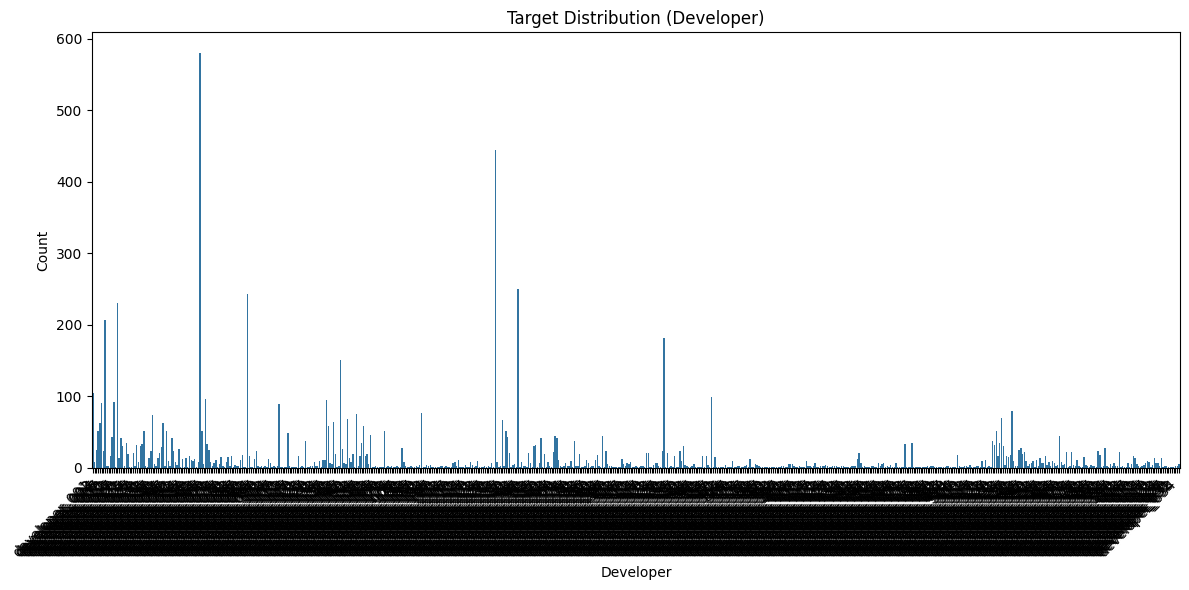

In [ ]:
# plot taregt disctirbution for developer

plt.figure(figsize=(12, 6))
sns.countplot(x='developer', data=df)
plt.title('Target Distribution (Developer)')
plt.xlabel('Developer')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# Count the occurrences of each developer
developer_counts = df['developer'].value_counts()
print(developer_counts)

# Get the total number of developers
total_developers = len(developer_counts)
print(f"\nTotal number of developers: {total_developers}")


developer
developer_064    580
developer_232    444
developer_245    250
developer_091    243
developer_018    230
                ... 
developer_630      1
developer_631      1
developer_025      1
developer_024      1
developer_017      1
Name: count, Length: 619, dtype: int64

Total number of developers: 619


In [ ]:
# Group by developer and count the number of bugs
developer_bug_counts = df.groupby('developer')['developer'].count().reset_index(name='bug_count')

# Sort by bug count in descending order and select the top 30
top_30_developers = developer_bug_counts.sort_values('bug_count', ascending=False).head(30)

# Print the developer name and bug count
print(top_30_developers[['developer', 'bug_count']])

         developer  bug_count
62   developer_064        580
230  developer_232        444
243  developer_245        250
89   developer_091        243
17   developer_018        230
8    developer_009        207
326  developer_329        182
143  developer_145        151
0    developer_001        105
353  developer_356         99
65   developer_067         96
135  developer_137         95
15   developer_016         92
5    developer_006         90
107  developer_109         89
523  developer_539         79
188  developer_190         77
152  developer_154         75
36   developer_037         74
517  developer_533         69
147  developer_149         68
234  developer_236         67
139  developer_141         64
4    developer_005         62
42   developer_044         62
156  developer_158         59
136  developer_138         58
3    developer_004         52
236  developer_238         52
63   developer_065         52


In [ ]:
# Create a new DataFrame containing only the top 30 developers
top_30_df = df[df['developer'].isin(top_30_developers['developer'])]

print(top_30_df.head())

   bug_id                                        description      developer  \
0  323798                  Keyword URL Needs to be localized  developer_001   
4  322290  Queries in the bookmark toolbar/menu don't act...  developer_004   
5  324202  Don't Change the title of feed items to the ti...  developer_005   
6  324948  Bookmark management should work when parent is...  developer_006   
9  325163                    Fully support remote containers  developer_004   

  severity priority  project  
0   normal       P1  Firefox  
4    major       P2  Firefox  
5   normal       P2  Firefox  
6   normal       P2  Firefox  
9   normal       P2  Firefox  


In [ ]:
#  Drop the 'project' column if it exists
if 'project' in top_30_df.columns:
    top_30_df = top_30_df.drop('project', axis=1)

print(top_30_df.head())

   bug_id                                        description      developer  \
0  323798                  Keyword URL Needs to be localized  developer_001   
4  322290  Queries in the bookmark toolbar/menu don't act...  developer_004   
5  324202  Don't Change the title of feed items to the ti...  developer_005   
6  324948  Bookmark management should work when parent is...  developer_006   
9  325163                    Fully support remote containers  developer_004   

  severity priority  
0   normal       P1  
4    major       P2  
5   normal       P2  
6   normal       P2  
9   normal       P2  


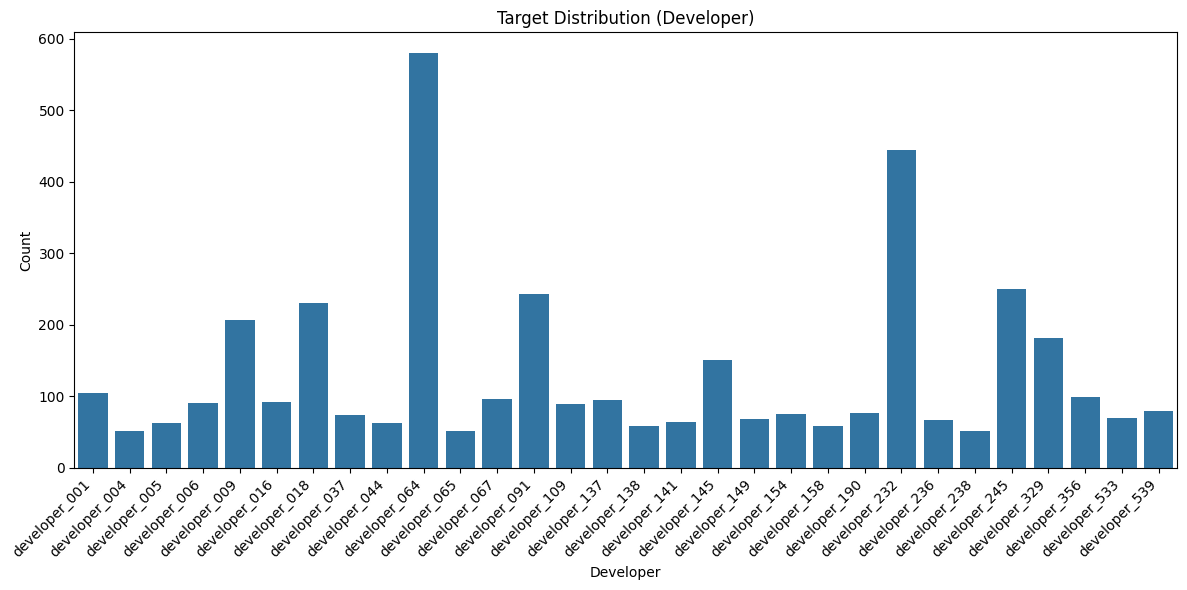

In [ ]:
# plot taregt disctirbution for developer

plt.figure(figsize=(12, 6))
sns.countplot(x='developer', data=top_30_df)
plt.title('Target Distribution (Developer)')
plt.xlabel('Developer')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Handle class imbalance

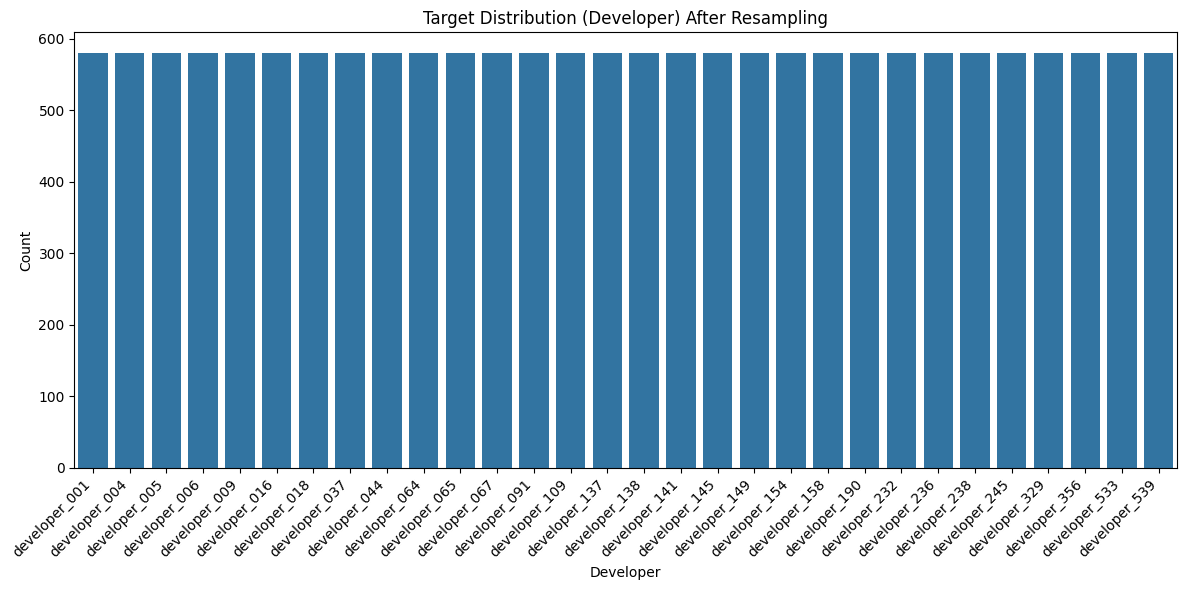

In [ ]:
# handle class imbalance
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=42)  # Or SMOTE, RandomUnderSampler, etc.

# Resample the data
X = top_30_df.drop('developer', axis=1)  # Features (excluding the target)
y = top_30_df['developer']  # Target variable
X_resampled, y_resampled = sampler.fit_resample(X, y)

# Convert the resampled data back to a DataFrame
top_30_df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
top_30_df_resampled['developer'] = y_resampled


# Verify the class distribution after resampling
plt.figure(figsize=(12, 6))
sns.countplot(x='developer', data=top_30_df_resampled)
plt.title('Target Distribution (Developer) After Resampling')
plt.xlabel('Developer')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
top_30_df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17400 entries, 0 to 17399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   bug_id       17400 non-null  int64 
 1   description  17400 non-null  object
 2   severity     17400 non-null  object
 3   priority     17400 non-null  object
 4   developer    17400 non-null  object
dtypes: int64(1), object(4)
memory usage: 679.8+ KB


In [ ]:
print(top_30_df_resampled.head())

   bug_id                                        description severity  \
0  323798                  Keyword URL Needs to be localized   normal   
1  322290  Queries in the bookmark toolbar/menu don't act...    major   
2  324202  Don't Change the title of feed items to the ti...   normal   
3  324948  Bookmark management should work when parent is...   normal   
4  325163                    Fully support remote containers   normal   

  priority      developer  
0       P1  developer_001  
1       P2  developer_004  
2       P2  developer_005  
3       P2  developer_006  
4       P2  developer_004  


# Feature Engineering

In [ ]:
# convert categorical severity and priority to numerical values.
severity_mapping = {"blocker": 0, "critical": 1, "major": 2, "normal": 3, "minor": 4, "trivial": 5}
priority_mapping = {"P1": 0, "P2": 1, "P3": 2, "P4": 3, "P5": 4}

# Apply mappings
top_30_df_resampled['severity'] = top_30_df_resampled['severity'].map(severity_mapping)
top_30_df_resampled['priority'] = top_30_df_resampled['priority'].map(priority_mapping)


In [ ]:
top_30_df_resampled.head()

,bug_id,description,severity,priority,developer
0,323798,Keyword URL Needs to be localized,3,0,developer_001
1,322290,Queries in the bookmark toolbar/menu don't act...,2,1,developer_004
2,324202,Don't Change the title of feed items to the ti...,3,1,developer_005
3,324948,Bookmark management should work when parent is...,3,1,developer_006
4,325163,Fully support remote containers,3,1,developer_004


In [ ]:
# Preprocess data
bug_descriptions = top_30_df_resampled['description'].values
developer_ids = top_30_df_resampled['developer'].values

severity = top_30_df_resampled['severity'].values
priority = top_30_df_resampled['priority'].values

# Train/test split

In [ ]:
# Encode developer IDs
label_encoder = LabelEncoder()
encoded_developer_ids = label_encoder.fit_transform(developer_ids)

# Split data into training and testing sets
X_train_desc, X_test_desc, X_train_sev, X_test_sev, X_train_pri, X_test_pri, y_train, y_test = train_test_split(
    bug_descriptions, severity, priority, encoded_developer_ids, test_size=0.2, random_state=42
)

# BERT Tokenizer

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize bug descriptions
X_train_desc_tokens = tokenizer(X_train_desc.tolist(), padding='max_length', truncation=True, return_tensors='tf', max_length=128)
X_test_desc_tokens = tokenizer(X_test_desc.tolist(), padding='max_length', truncation=True, return_tensors='tf', max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased') # not used

# Input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')
severity_input = Input(shape=(1,), dtype=tf.float32, name='severity_input')
priority_input = Input(shape=(1,), dtype=tf.float32, name='priority_input')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
from tensorflow.keras.layers import Layer

class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained("bert-base-uncased")

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.bert(input_ids=input_ids, attention_mask=attention_mask)[0] # [0] to take last hidden states

    def get_config(self):
        config = super(BertLayer, self).get_config()
        return config

In [ ]:
# Use the custom BERT layer
bert_output = BertLayer()([input_ids, attention_mask])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# CNN & Bi-LSTM

In [ ]:
# CNN layer
cnn_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(bert_output)
cnn_layer = GlobalMaxPooling1D()(cnn_layer)


# Bi-LSTM layer
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(bert_output)
lstm_layer = GlobalAveragePooling1D()(lstm_layer)


# Embedding Layers
severity_embedding = Embedding(input_dim=6, output_dim=4)(severity_input)
priority_embedding = Embedding(input_dim=5, output_dim=4)(priority_input)

# Flatten embeddings
severity_embedding = Flatten()(severity_embedding)
priority_embedding = Flatten()(priority_embedding)


# Concatenate all features - fature fusion
concat_layer = Concatenate()([cnn_layer, lstm_layer, severity_embedding, priority_embedding])


# Model Summary

In [ ]:
# Dense layers
dense_layer = Dense(128, activation='relu')(concat_layer) # feature extractor
dense_layer = Dropout(0.5)(dense_layer) # to prevent overfitting
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_layer) # classifier

# Compile the model
model = Model(inputs=[input_ids, attention_mask, severity_input, priority_input], outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer          │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ severity_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ priority_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 32)   │     73,760 │ bert_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 128)  │    426,496 │ bert_layer[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 4)      │         24 │ severity_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 4)      │         20 │ priority_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 168)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     21,632 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │      3,870 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 525,802 (2.01 MB)

 Trainable params: 525,802 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

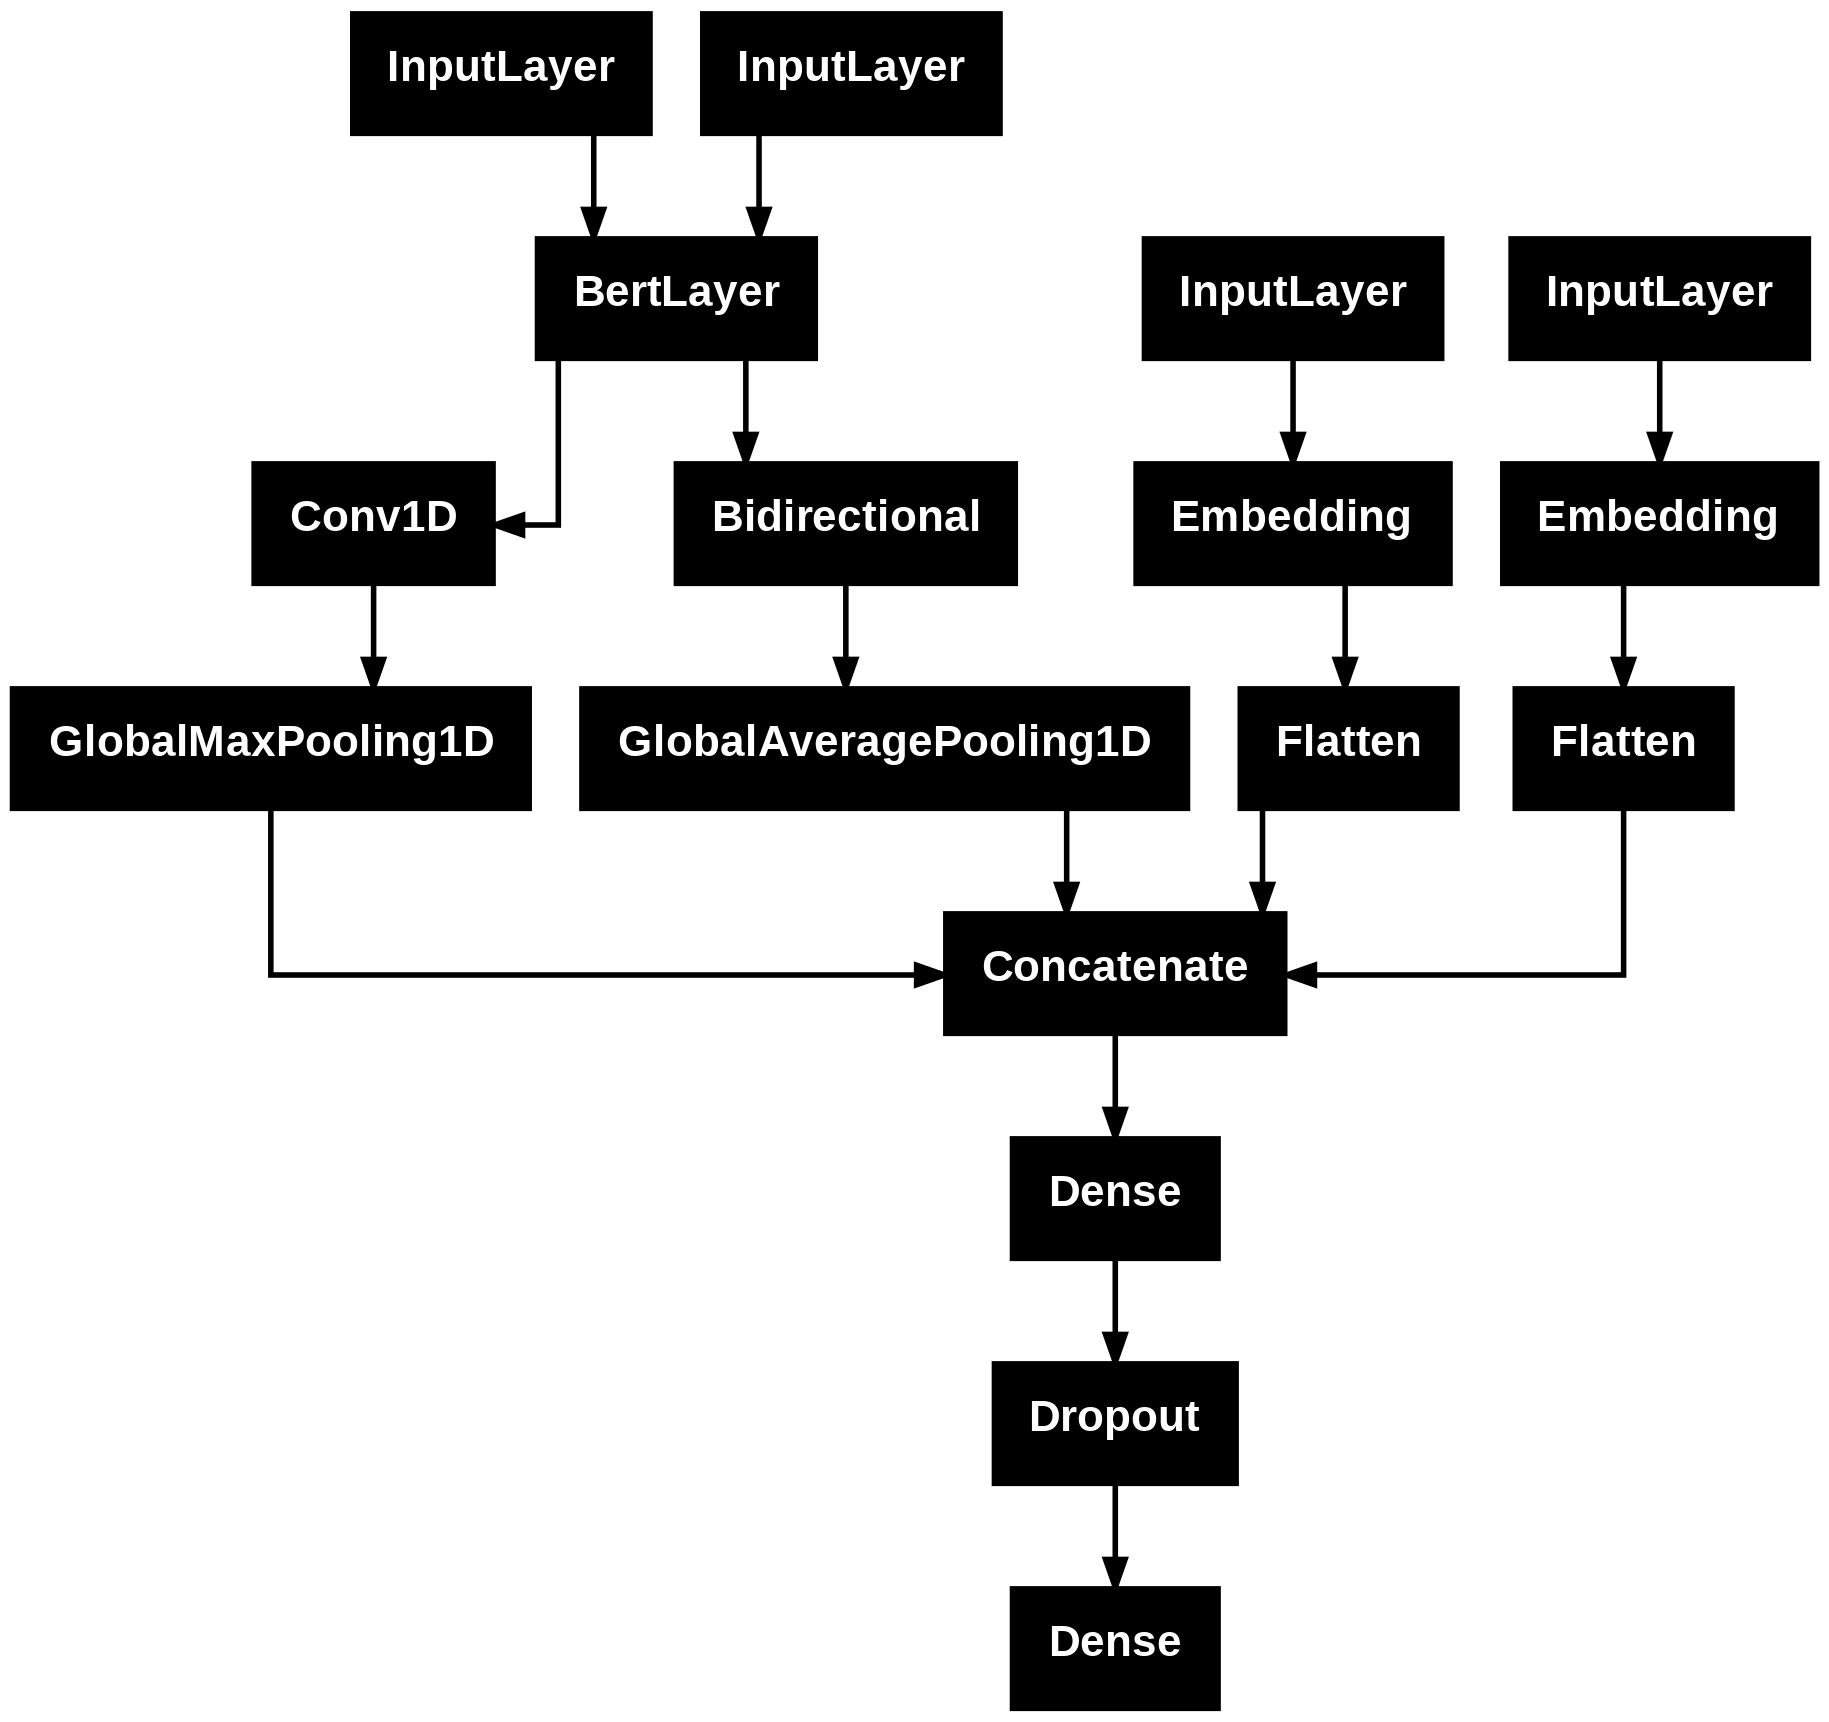

In [ ]:
tf.keras.utils.plot_model(model)

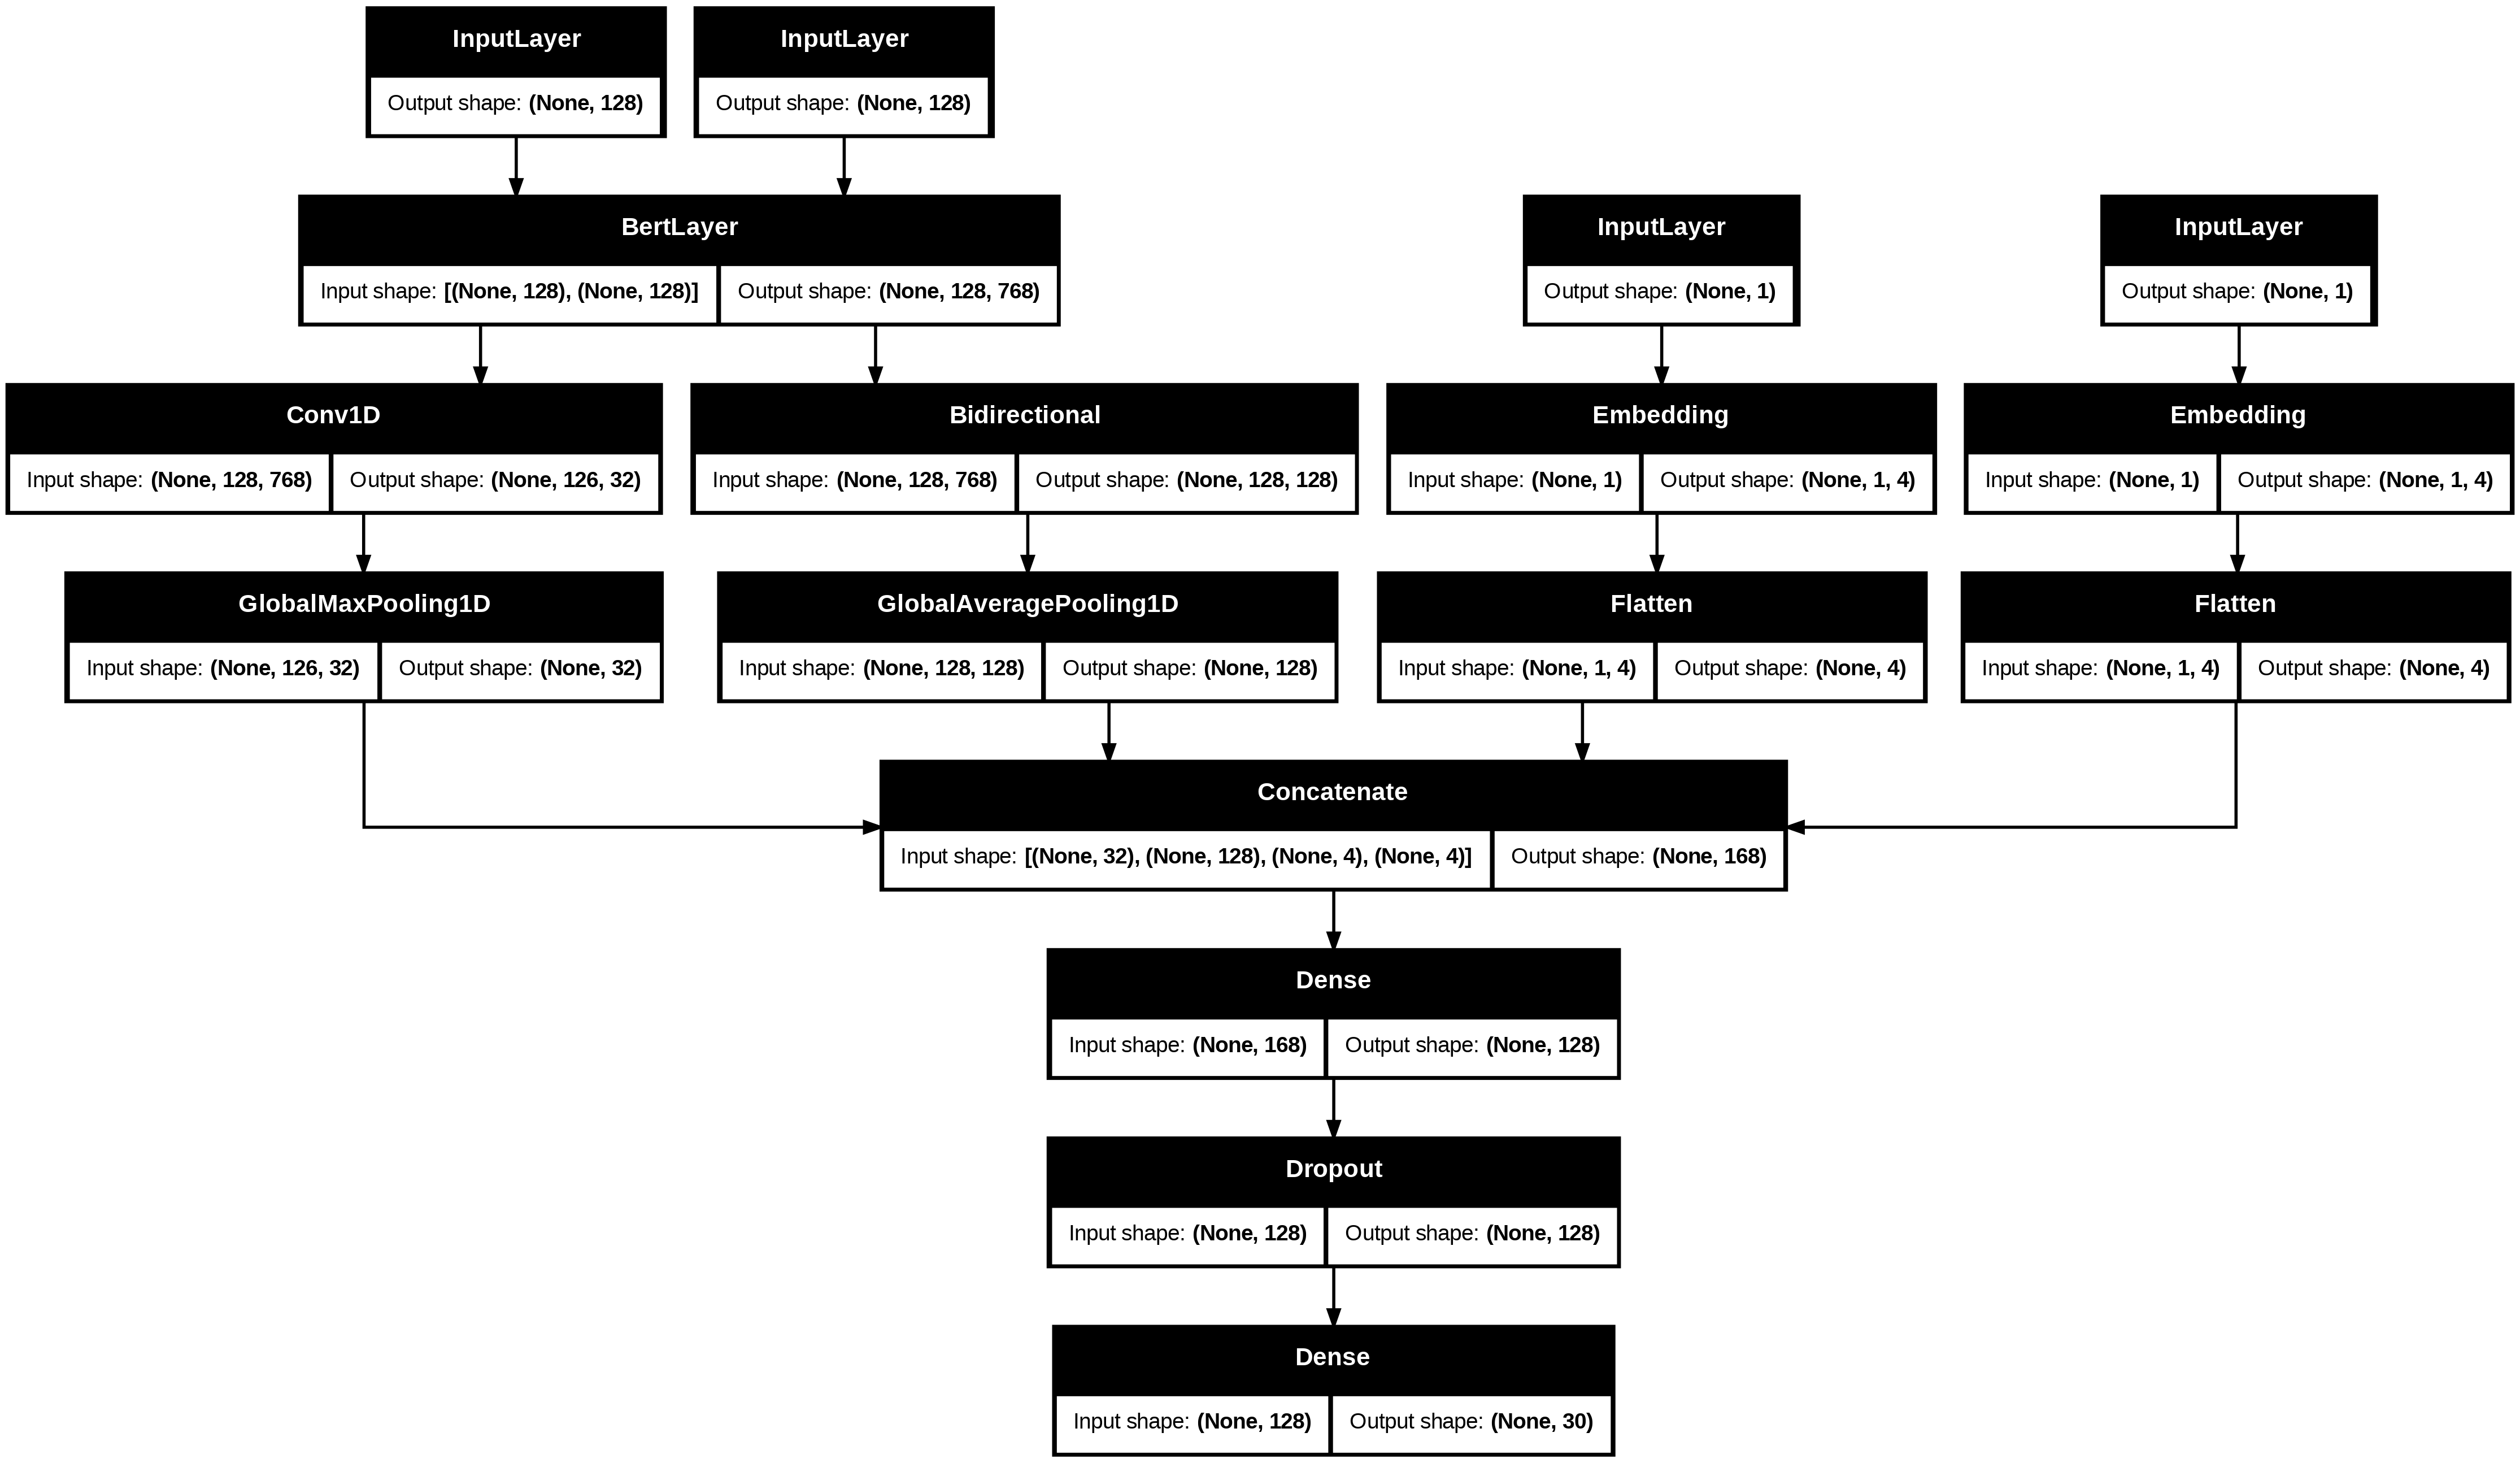

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Model Training

In [ ]:
# Prepare inputs for training
train_inputs = {
    'input_ids': X_train_desc_tokens['input_ids'],
    'attention_mask': X_train_desc_tokens['attention_mask'],
    'severity_input': np.array(X_train_sev, dtype=np.float32).reshape(-1, 1),
    'priority_input': np.array(X_train_pri, dtype=np.float32).reshape(-1, 1)
}

In [ ]:
print("Input IDs shape:", X_train_desc_tokens["input_ids"].shape)
print("Attention mask shape:", X_train_desc_tokens["attention_mask"].shape)
print("Severity shape:", np.array(X_train_sev).shape)
print("Priority shape:", np.array(X_train_pri).shape)
print("Labels shape:", y_train.shape)


Input IDs shape: (13920, 128)
Attention mask shape: (13920, 128)
Severity shape: (13920,)
Priority shape: (13920,)
Labels shape: (13920,)


In [ ]:
# Train the model
history = model.fit(train_inputs, y_train, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5
696/696 ━━━━━━━━━━━━━━━━━━━━ 152s 199ms/step - accuracy: 0.1198 - loss: 3.1636 - val_accuracy: 0.4583 - val_loss: 2.1044
Epoch 2/5
696/696 ━━━━━━━━━━━━━━━━━━━━ 198s 200ms/step - accuracy: 0.4114 - loss: 2.0868 - val_accuracy: 0.6088 - val_loss: 1.4786
Epoch 3/5
696/696 ━━━━━━━━━━━━━━━━━━━━ 141s 203ms/step - accuracy: 0.5897 - loss: 1.4492 - val_accuracy: 0.7364 - val_loss: 1.0350
Epoch 4/5
696/696 ━━━━━━━━━━━━━━━━━━━━ 144s 207ms/step - accuracy: 0.7169 - loss: 1.0051 - val_accuracy: 0.8254 - val_loss: 0.7326
Epoch 5/5
696/696 ━━━━━━━━━━━━━━━━━━━━ 202s 206ms/step - accuracy: 0.7962 - loss: 0.7424 - val_accuracy: 0.8675 - val_loss: 0.5442


In [ ]:
# Prepare inputs for testing
test_inputs = {
    'input_ids': X_test_desc_tokens['input_ids'],
    'attention_mask': X_test_desc_tokens['attention_mask'],
    'severity_input': np.array(X_test_sev, dtype=np.float32).reshape(-1, 1),
    'priority_input': np.array(X_test_pri, dtype=np.float32).reshape(-1, 1)
}

# Evaluate the model
loss, accuracy = model.evaluate(test_inputs, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 288ms/step - accuracy: 0.8604 - loss: 0.5545
Test Loss: 0.5545910000801086
Test Accuracy: 0.8571839332580566


# Traning and validation loss

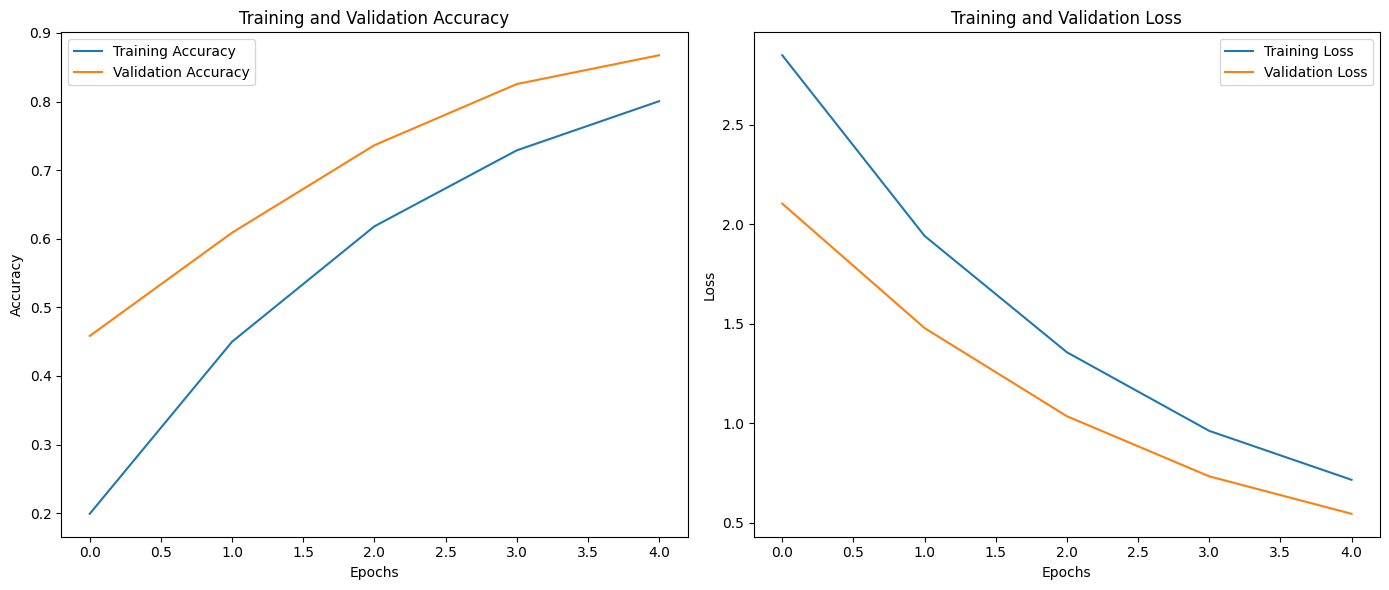

In [ ]:
# Create two subplots for training and validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation accuracy on the first subplot
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_title('Training and Validation Accuracy')

# Plot training and validation loss on the second subplot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_title('Training and Validation Loss')

# Display the plots
plt.tight_layout()
plt.show()

Confusion Matrix

109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 310ms/step


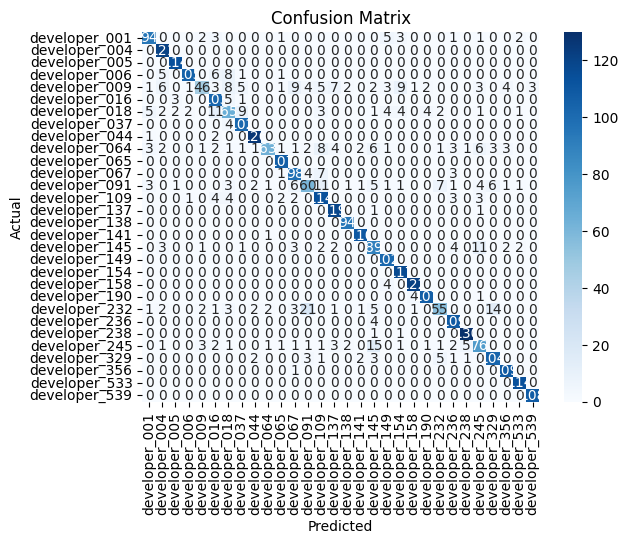

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(test_inputs)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Classification report

In [ ]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

developer_001       0.87      0.84      0.85       112
developer_004       0.85      1.00      0.92       121
developer_005       0.95      1.00      0.97       114
developer_006       0.96      0.83      0.89       126
developer_009       0.84      0.37      0.51       125
developer_016       0.75      0.92      0.83       112
developer_018       0.64      0.56      0.60       116
developer_037       0.85      0.96      0.90       106
developer_044       0.95      0.98      0.96       129
developer_064       0.93      0.54      0.68       116
developer_065       0.93      1.00      0.96       107
developer_067       0.79      0.87      0.83       113
developer_091       0.63      0.52      0.57       116
developer_109       0.75      0.86      0.80       133
developer_137       0.88      0.98      0.93       121
developer_138       0.95      1.00      0.97        94
developer_141       0.95      0.99      0.97       111
developer

# Predictions

In [ ]:
# Display some predictions
for i in range(6):
    print(f"Bug Description: {X_test_desc[i]}")
    print(f"Actual Developer: {label_encoder.inverse_transform([y_test[i]])[0]}")
    print(f"Predicted Developer: {label_encoder.inverse_transform([y_pred_classes[i]])[0]}")
    print()

Bug Description: Middle clicking an item in the places view should open it in a new tab
Actual Developer: developer_006
Predicted Developer: developer_006

Bug Description: CNN Video page will not load
Actual Developer: developer_044
Predicted Developer: developer_044

Bug Description: [@font-face] empty span using specified font prevents use of font on subsequent elements
Actual Developer: developer_236
Predicted Developer: developer_236

Bug Description: Setting browser.chrome.favicons to false still displays site icons
Actual Developer: developer_009
Predicted Developer: developer_009

Bug Description: Unmounting file system crashes Firefox
Actual Developer: developer_137
Predicted Developer: developer_137

Bug Description: nsDOMStorage should have an mPrincipal, not mURI
Actual Developer: developer_044
Predicted Developer: developer_044



In [ ]:
# Predict the most suitable developer for a new bug
new_bug_description = "Keyword URL Needs to be localized"
new_severity = 3
new_priority = 1

# Tokenize the new bug description
new_bug_tokens = tokenizer([new_bug_description], padding='max_length', truncation=True, return_tensors='tf', max_length=128)

# Prepare inputs for prediction
prediction_inputs = {
    'input_ids': new_bug_tokens['input_ids'],
    'attention_mask': new_bug_tokens['attention_mask'],
    'severity_input': np.array([new_severity], dtype=np.float32).reshape(-1, 1),
    'priority_input': np.array([new_priority], dtype=np.float32).reshape(-1, 1)
}

# Make prediction
predicted_probabilities = model.predict(prediction_inputs)
predicted_developer_id = np.argmax(predicted_probabilities, axis=1)

# Decode the predicted developer ID
predicted_developer = label_encoder.inverse_transform(predicted_developer_id)
print(f'Bug report description: {new_bug_description}')
print(f'Predicted Developer: {predicted_developer[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Bug report description: Keyword URL Needs to be localized
Predicted Developer: developer_001


In [ ]:
# Predict the most suitable developer for a new bug
new_bug_description = "Localization is required for the keyword URL"
new_severity = 3
new_priority = 1

# Tokenize the new bug description
new_bug_tokens = tokenizer([new_bug_description], padding='max_length', truncation=True, return_tensors='tf', max_length=128)

# Prepare inputs for prediction
prediction_inputs = {
    'input_ids': new_bug_tokens['input_ids'],
    'attention_mask': new_bug_tokens['attention_mask'],
    'severity_input': np.array([new_severity], dtype=np.float32).reshape(-1, 1),
    'priority_input': np.array([new_priority], dtype=np.float32).reshape(-1, 1)
}

# Make prediction
predicted_probabilities = model.predict(prediction_inputs)
predicted_developer_id = np.argmax(predicted_probabilities, axis=1)

# Decode the predicted developer ID
predicted_developer = label_encoder.inverse_transform(predicted_developer_id)
print(f'Bug report description: {new_bug_description}')
print(f'Predicted Developer: {predicted_developer[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Bug report description: Localization is required for the keyword URL
Predicted Developer: developer_001


In [ ]:
# Predict the most suitable developer for a new bug
new_bug_description = "Firefox crashes in unmounting file system"
new_severity = 3.0
new_priority = 1.0

# Tokenize the new bug description
new_bug_tokens = tokenizer([new_bug_description], padding='max_length', truncation=True, return_tensors='tf', max_length=128)

# Prepare inputs for prediction
prediction_inputs = {
    'input_ids': new_bug_tokens['input_ids'],
    'attention_mask': new_bug_tokens['attention_mask'],
    'severity_input': np.array([new_severity], dtype=np.float32).reshape(-1, 1),
    'priority_input': np.array([new_priority], dtype=np.float32).reshape(-1, 1)
}

# Make prediction
predicted_probabilities = model.predict(prediction_inputs)
predicted_developer_id = np.argmax(predicted_probabilities, axis=1)

# Decode the predicted developer ID
predicted_developer = label_encoder.inverse_transform(predicted_developer_id)
print(f'Bug report description: {new_bug_description}')
print(f'Predicted Developer: {predicted_developer[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Bug report description: Firefox crashes in unmounting file system
Predicted Developer: developer_137


In [ ]:
# Predict the most suitable developer for a new bug
new_bug_description = "Unmounting file system crashes Firefox"
new_severity = 1.0
new_priority = 5.0

# Tokenize the new bug description
new_bug_tokens = tokenizer([new_bug_description], padding='max_length', truncation=True, return_tensors='tf', max_length=128)

# Prepare inputs for prediction
prediction_inputs = {
    'input_ids': new_bug_tokens['input_ids'],
    'attention_mask': new_bug_tokens['attention_mask'],
    'severity_input': np.array([new_severity], dtype=np.float32).reshape(-1, 1),
    'priority_input': np.array([new_priority], dtype=np.float32).reshape(-1, 1)
}

# Make prediction
predicted_probabilities = model.predict(prediction_inputs)
predicted_developer_id = np.argmax(predicted_probabilities, axis=1)

# Decode the predicted developer ID
predicted_developer = label_encoder.inverse_transform(predicted_developer_id)
print(f'Bug report description: {new_bug_description}')
print(f'Predicted Developer: {predicted_developer[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Bug report description: Unmounting file system crashes Firefox
Predicted Developer: developer_137


# Save the model

In [ ]:
# model.save('/models/bug_triage_model_1.h5')
model.save('/content/drive/MyDrive/BugTriage/models/bug_triage_model_v1.h5')

In [ ]:
# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/BugTriage/models/tokenizer_v1')

('/content/drive/MyDrive/BugTriage/models/tokenizer_v1/tokenizer_config.json',
 '/content/drive/MyDrive/BugTriage/models/tokenizer_v1/special_tokens_map.json',
 '/content/drive/MyDrive/BugTriage/models/tokenizer_v1/vocab.txt',
 '/content/drive/MyDrive/BugTriage/models/tokenizer_v1/added_tokens.json')

In [ ]:
# Save the label encoder
import joblib
joblib.dump(label_encoder, '/content/drive/MyDrive/BugTriage/models/label_encoder_v1.pkl')

['/content/drive/MyDrive/BugTriage/models/label_encoder_v1.pkl']